# Conjugate Priors

*Notebook to implement conjugate prior evaluation on pymc3*

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

from scipy import stats

import torch
import ddks

In [3]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Kullback-Leibler Divergence

In [488]:
#TODO: Refactor pdf_space to take a pdf argument and define the limits of the space according to the largest values within the space.

In [484]:
def generate_array(start, end, n):
    # Generate an array with values from start to end with decreasing intervals
    if end == np.inf:
        arr = np.cumsum(np.exp(np.linspace(0, 5, n)))
        # No need to normalize to end value, since it is infinite
        arr = (arr - arr[0])
    else:
        arr = np.cumsum(np.exp(-np.linspace(0, 5, n)))
        # Normalize the array to ensure it ranges from start to end
        arr = (arr - arr[0]) / (arr[-1] - arr[0]) * (end - start) + start
    
    return arr

def pdf_space(start, end, n = 10000):
    mean = np.array([start, end]).mean()
    arr2 = generate_array(mean, end, int(n/2))
    arr1 = generate_array(-mean, -start, int(n/2)) * -1
    return np.concatenate([arr1[::-1], arr2])

In [486]:
#(a+b)h/2

def integrate(function, space):
    y = function(space)

    h = np.diff(space)

    return np.sum((y[1:] + y[:-1]) * h / 2)

# calculate kullback leibler divergence using integrate function
def kl_divergence(p, q, start, end):
    space = pdf_space(start, end)
    print(space)
    return integrate(lambda x: p.pdf(x) * np.log(p.pdf(x) / q.pdf(x)), space)

In [487]:
kl_divergence(stats.norm(10, 7), stats.norm(5,7), -np.inf, np.inf)

[-147457.39533719 -147308.98217809 -147160.71738763 ...  147160.71738763
  147308.98217809  147457.39533719]


/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_11051/3519533463.py:14: RuntimeWarning: divide by zero encountered in divide
  return integrate(lambda x: p.pdf(x) * np.log(p.pdf(x) / q.pdf(x)), space)
/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_11051/3519533463.py:14: RuntimeWarning: invalid value encountered in divide
  return integrate(lambda x: p.pdf(x) * np.log(p.pdf(x) / q.pdf(x)), space)
/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_11051/3519533463.py:14: RuntimeWarning: divide by zero encountered in log
  return integrate(lambda x: p.pdf(x) * np.log(p.pdf(x) / q.pdf(x)), space)
/var/folders/00/6xcw025x5gsfz5jq546hv_kc0000gn/T/ipykernel_11051/3519533463.py:14: RuntimeWarning: invalid value encountered in multiply
  return integrate(lambda x: p

nan

## Normal distribution with known variance, unknown mean

$$
\sigma = 1\\
$$

$$
P(x|\Theta) \sim \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(\mu, 1)\\
$$

$$
P(\theta | \Theta) \sim \mathcal{N}(\mu_0, \sigma_0^2)\\
$$

$$
P(\tilde{x}|\Theta') \sim \mathcal{N}(\frac{1}{\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}}(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^nx_i}{\sigma^2}), (\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2})^{-1})
$$

### Scratch

In [4]:
n = 1000
sigma = 3
mu = 9

X = rng.normal(size = n, loc = mu, scale = sigma)
prior_mean = 6
prior_std = 3

posterior_mean = np.power((1/np.power(prior_std, 2))+(n/np.power(sigma,2)), -1)*((prior_mean/np.power(prior_std, 2)) + (X.sum()/np.power(sigma, 2)))
posterior_std = np.power((1 / np.power(prior_std, 2)) + (n/np.power(sigma, 2)), -1)

scratch_prior = stats.norm(prior_mean, prior_std)
scratch_predictive = stats.norm(posterior_mean, posterior_std + prior_std)

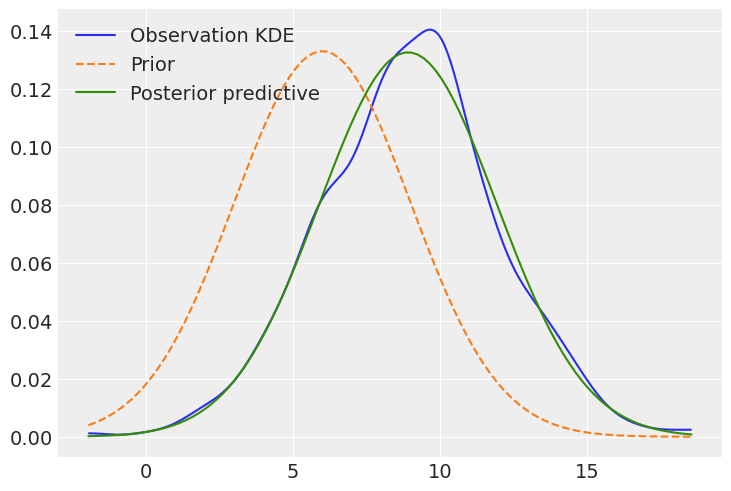

In [5]:
fig, ax = plt.subplots()

az.plot_kde(X, ax = ax, label="Observation KDE")
x = np.linspace(X.min(), X.max(), 100)
ax.plot(x, scratch_prior.pdf(x), color = "C1", linestyle = "--", label = "Prior")
ax.plot(x, scratch_predictive.pdf(x), color = "C2", label = "Posterior predictive")
ax.legend(loc=2)
plt.show();

### PyMC3

In [6]:
with pm.Model() as m:
    # Estimating mean of the data, and first guess is that it follows Normal distribution with mean 3 and std 1
    mu = pm.Normal("mu", mu = 3, sigma = 3)
    obs = pm.Normal("obs", mu = mu, sigma = 3, observed = X)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [mu, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [obs]


Output()

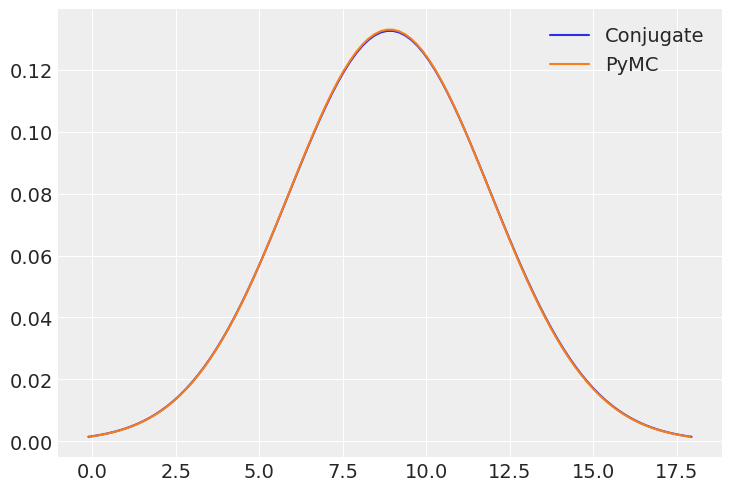

In [7]:
prior = idata.prior
post = idata.posterior

pp_mean = post["mu"].mean()

# Exact calculation
pred_std = posterior_std + prior_std
z1 = np.linspace(posterior_mean - 3* pred_std, posterior_mean + 3*pred_std, 100)
conj_pdf= stats.norm(posterior_mean, pred_std).pdf(z1)

#Pymc params
z2 = np.linspace(pp_mean - 9, pp_mean + 9, 100)
pymc_pdf = stats.norm(pp_mean, 3).pdf(z2)

fig, ax = plt.subplots()
ax.plot(z1, conj_pdf, label = "Conjugate")
ax.plot(z2, pymc_pdf, label = "PyMC")
ax.legend()
plt.show();


#### DDKS

In [8]:
pymc_samples = torch.Tensor(stats.norm(pp_mean, 3).rvs(100).reshape(-1, 1))
conj_samples= torch.Tensor(stats.norm(posterior_mean, pred_std).rvs(100).reshape(-1, 1))

calculation = ddks.methods.ddKS()
distance = calculation(conj_samples, pymc_samples)
print(f"The ddKS distance is {distance}")

The ddKS distance is 0.11000001430511475


In [14]:
kl_divergence(scratch_predictive, stats.norm(pp_mean, 3), -10, 20, 1000)

4.314085088785481e-06

## Normal with known mean $\mu$

$$
\mu = 0\\
$$

$$
P(x_i | \theta) \sim \mathcal{N}(\mu, \sigma^2)\\
$$

$$
P(\theta | \Theta) \sim \mathcal{N}(\nu, \sigma_0^2)\\
$$

$$
P(\theta | \Theta') \sim \mathcal{N} (\nu + \eta, \frac{\nu \sigma_0^2 + \sum_{i=1}^n ( x_i - \mu)^2}{\nu + \eta})\\
$$

$$
P(\tilde{x} | \Theta') \sim \mathcal{t}_{\nu'}(\tilde{x} | \mu, \sigma_{0}^{2'})
$$

### Scratch

In [15]:
n = 1000
mu = 0
prior_alpha = 1
prior_beta = 1

X = stats.norm.rvs(loc = mu, scale = 0.9, size = n)

posterior_alpha = prior_alpha + n/2
posterior_beta = prior_beta + 0.5 * np.sum(np.power(X - mu, 2))

predictive = stats.t(posterior_alpha, loc = mu, scale = np.sqrt(posterior_beta/posterior_alpha))

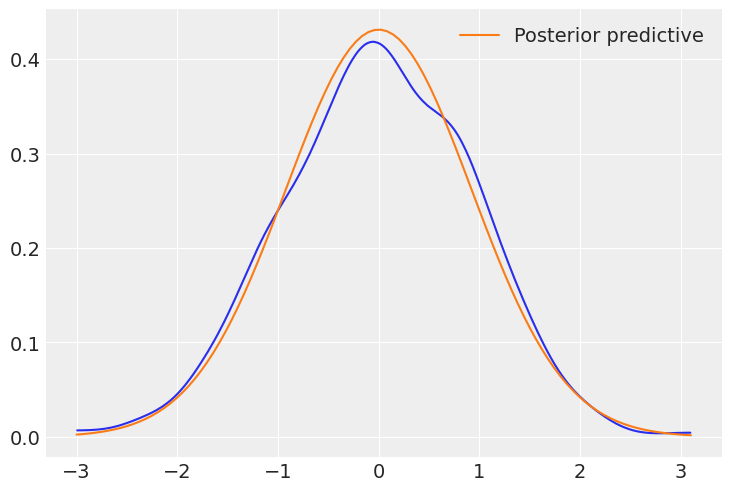

In [16]:
fig, ax = plt.subplots()

az.plot_kde(X, ax = ax)
x = np.linspace(X.min(), X.max(), 100)
ax.plot(x, predictive.pdf(x), color = "C1", label = "Posterior predictive")
ax.legend()
plt.show();

### PyMC3

In [17]:
with pm.Model() as m:
    # Priors for unknown model parameters
    sigma = pm.InverseGamma("sigma", alpha = 1, beta = 1)
    
    # Likelihood
    obs = pm.Normal("obs", mu = 0, sigma = sigma, observed = X)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [obs, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Sampling: [obs]


Output()

<Axes: xlabel='obs'>

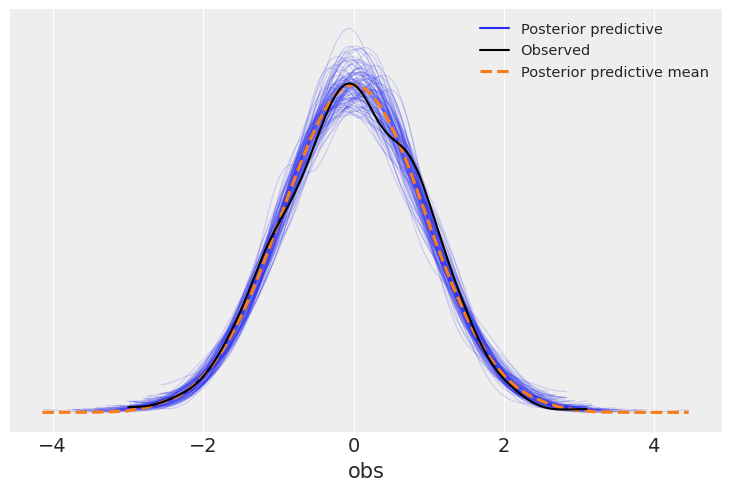

In [18]:
az.plot_ppc(
    idata,
    data_pairs = {
        "obs": "obs",
        "prior": "obs"
        },
    num_pp_samples=100
    )

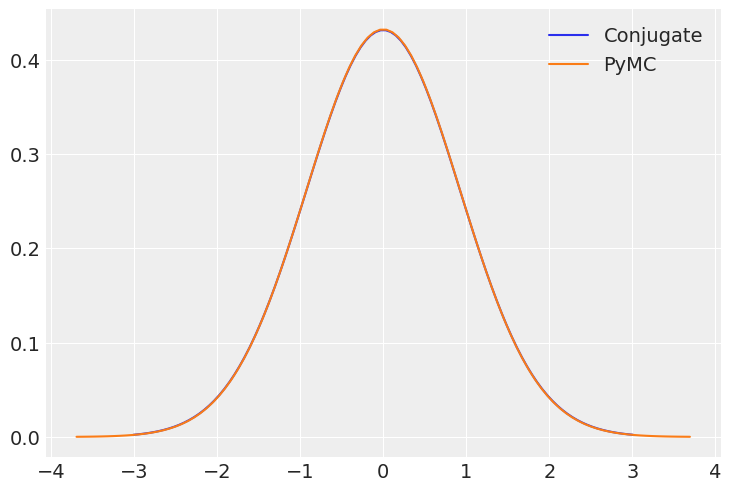

In [19]:
post = idata.posterior

post_std = post["sigma"].mean().round(4).values

# Exact calculation
conj_std = np.sqrt(posterior_alpha/(posterior_alpha-2))
z1 = np.linspace(0-3*conj_std, 0+3*conj_std, 100)
conj_pred = predictive.pdf(z1)

#Pymc params
z2 = np.linspace(0 - 4* post_std, 0 + 4*post_std, 100)
pymc_pred = stats.norm(0, post_std).pdf(z2)

fig, ax = plt.subplots()
ax.plot(z1, conj_pred, label = "Conjugate")
ax.plot(z2, pymc_pred, label = "PyMC")
ax.legend()
plt.show();


In [20]:
kl_divergence(predictive, stats.norm(0, post_std), -10, 10, 1000)

1.2935488918598623e-05

## Multivariate Normal with known covariance $\mathbf{\Sigma}$

$$
\mathbf{\Sigma} = \begin{pmatrix}
\text{Var}(X) & \text{Cov}(X,Y) & \text{Cov}(X,Z) \\
\text{Cov}(Y,X) & \text{Var}(Y) & \text{Cov}(Y,Z) \\
\text{Cov}(Z,X) & \text{Cov}(Z,Y) & \text{Var}(Z) \\
\end{pmatrix}\\
$$

$$
P(x_i | \theta) \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})\\
$$

$$
P(\theta | \Theta) \sim \mathcal{N}(\mu_0, \mathbf{\Sigma_0})\\
$$

$$
P(\theta | \Theta') \sim \mathcal{N}((\mathbf{\Sigma}_0^{-1} + n\mathbf{\Sigma}^{-1})^{-1}(\mathbf{\Sigma}_0^{-1}\mu_0 + n\mathbf{\Sigma}^{-1}\mathbf{\bar{x}}), (\mathbf{\Sigma}_0^{-1}+n\mathbf{\Sigma}^{-1})^{-1})
$$

$$
P(\tilde{x}|\Theta') \sim \mathcal{N}(\mathbf{\tilde{x}}|\mu_0', {\mathbf{\Sigma}_0' + \mathbf{\Sigma}})
$$

### Scratch

In [21]:
n = 1000
mu = np.array([3, 5])
cov = np.array([[1, 0.5], [0.5, 1]])

X = stats.multivariate_normal.rvs(mean = mu, cov = cov, size = n)

prior_mu = np.array([0, 0])
prior_cov = cov

posterior_mu = np.linalg.inv(np.linalg.inv(prior_cov) + n*np.linalg.inv(cov)) @ (np.linalg.inv(prior_cov) @ prior_mu + n * np.linalg.inv(cov) @ X.mean(axis = 0))
posterior_cov = np.linalg.inv(np.linalg.inv(prior_cov) + n*np.linalg.inv(cov))

predictive = stats.multivariate_normal(mean = posterior_mu, cov = posterior_cov + cov)

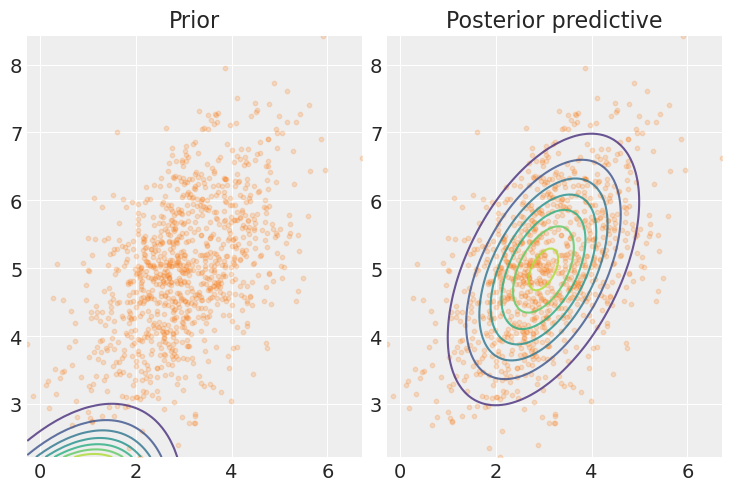

In [22]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
z2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

ax[0].contour(x, y, stats.multivariate_normal.pdf(pos, mean = prior_mu, cov = prior_cov), alpha = 0.8)
ax[1].contour(x, y, predictive.pdf(pos), alpha = 0.8)
ax[0].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Prior")
ax[1].set_title("Posterior predictive")

plt.show();

### PyMC3

In [23]:
with pm.Model() as m:
    # Priors for unknown model parameters
    mu = pm.MvNormal("mu", mu = [1,1], cov = cov, shape = 2)
    
    # Likelihood
    obs = pm.MvNormal("obs", mu = mu, cov = cov, observed = X)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [mu, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [obs]


Output()

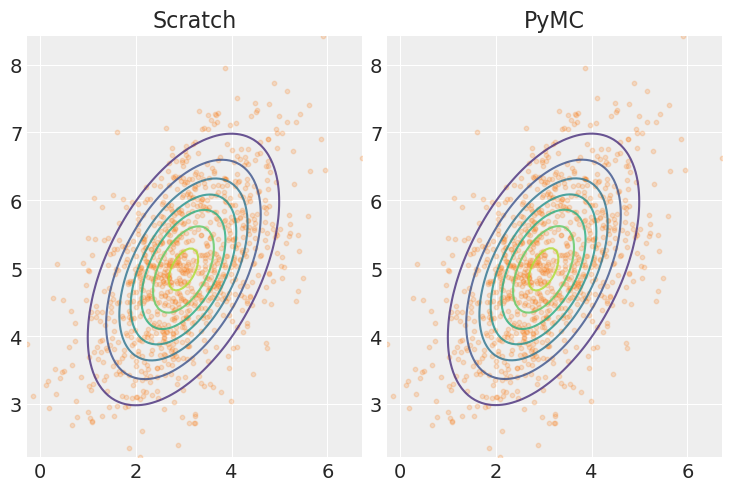

In [24]:
prior = idata.prior
post = idata.posterior

pp_mean = post["mu"].mean(axis = 0).mean(axis = 0)

# Set up the grid
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
z2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

# Exact calculation
ax[0].contour(x, y, predictive.pdf(pos), alpha = 0.8)
ax[0].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Scratch")

#Pymc params
ax[1].contour(x, y, stats.multivariate_normal.pdf(pos, mean = pp_mean, cov = cov), alpha = 0.8)
ax[1].scatter(X[:, 0], X[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].set_title("PyMC")

plt.show();


In [28]:
kl_divergence(predictive, stats.multivariate_normal(mean = pp_mean, cov = cov), -10, 10, 1000)

ValueError: operands could not be broadcast together with shapes (1,1000) (2,) 

## Multivariate Normal with known mean $\mu$

